In [1]:
!pip install ultralytics h5py opencv-python tqdm
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00
Mounted at /content/drive


In [4]:
import glob
import os
from google.colab import drive

# 1. On s'assure que le Drive est là
if not os.path.exists('/content/drive'):
    print("Montage du Drive en cours...")
    drive.mount('/content/drive')

print("🕵️ Recherche des fichiers .h5...")
# Recherche récursive (peut prendre 1 minute si le Drive est gros)
found_files = glob.glob("/content/drive/**/*.h5", recursive=True)

if len(found_files) > 0:
    print(f"✅ TROUVÉ ! {len(found_files)} fichiers détectés.")
    print(f"Exemple : {found_files[0]}")

    # On déduit le dossier parent automatiquement
    correct_path = os.path.dirname(found_files[0]) + "/"
    print(f"\n👇 COPIEZ CE CHEMIN EXACT POUR LA CELLULE 2 👇")
    print(f"SOURCE_DRIVE_PATH = '{correct_path}'")
else:
    print("❌ Aucun fichier trouvé. Vérifiez que vous êtes bien connecté au bon compte Google Drive.")

🕵️ Recherche des fichiers .h5...
✅ TROUVÉ ! 57195 fichiers détectés.
Exemple : /content/drive/MyDrive/Colab Notebooks/brain_segmentation/BraTS2020_training_data/content/data/volume_92_slice_57.h5

👇 COPIEZ CE CHEMIN EXACT POUR LA CELLULE 2 👇
SOURCE_DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/brain_segmentation/BraTS2020_training_data/content/data/'


In [5]:
import h5py
import numpy as np
import cv2
import glob
import random
import shutil
import os
from tqdm import tqdm

# --- CONFIGURATION ---
SOURCE_DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/brain_segmentation/BraTS2020_training_data/content/data/'
OUTPUT_BASE_DIR = "/content/datasets/brats_yolo_multiclass"
# --- ON PASSE A 7000 IMAGES ---
NUM_IMAGES_TO_PROCESS = 7000

def normalize_channel(channel):
    if np.max(channel) == np.min(channel): return np.zeros_like(channel, dtype=np.uint8)
    norm = (channel - np.min(channel)) / (np.max(channel) - np.min(channel))
    return (norm * 255).astype(np.uint8)

def mask_to_polygons(mask, class_id):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    H, W = mask.shape
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            cnt = cnt.flatten()
            relative_coords = []
            for i in range(0, len(cnt), 2):
                x = cnt[i] / W
                y = cnt[i+1] / H
                relative_coords.extend([x, y])
            polygons.append(f"{class_id} " + " ".join([f"{n:.6f}" for n in relative_coords]))
    return polygons

def prepare_dataset_final():
    # Nettoyage préalable
    if os.path.exists(OUTPUT_BASE_DIR): shutil.rmtree(OUTPUT_BASE_DIR)
    for split in ['train', 'val']:
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, 'labels', split), exist_ok=True)

    print("Listing des fichiers (ça peut prendre quelques secondes)...")
    files = glob.glob(os.path.join(SOURCE_DRIVE_PATH, "*.h5"))
    random.shuffle(files)

    # SÉLECTION DU SOUS-ENSEMBLE
    files_to_process = files[:NUM_IMAGES_TO_PROCESS]
    print(f"🚀 Démarrage de la conversion pour {len(files_to_process)} images...")

    for i, file_path in enumerate(tqdm(files_to_process)):
        try:
            # Split 80% Train / 20% Val
            split = 'train' if i < 0.8 * len(files_to_process) else 'val'
            base_name = os.path.splitext(os.path.basename(file_path))[0]

            with h5py.File(file_path, 'r') as f:
                img, mask = f['image'][:], f['mask'][:]

                # Fusion RGB (T1ce/FLAIR/T2)
                img_rgb = np.dstack((
                    normalize_channel(img[:, :, 2]),
                    normalize_channel(img[:, :, 3]),
                    normalize_channel(img[:, :, 1])
                ))
                cv2.imwrite(f"{OUTPUT_BASE_DIR}/images/{split}/{base_name}.jpg", img_rgb)

                # Labels
                polys = []
                for ch in range(3): # 0:Nécrose, 1:Œdème, 2:Tumeur
                    if np.max(mask[:,:,ch]) > 0:
                        polys.extend(mask_to_polygons(mask[:,:,ch], ch))

                if polys:
                    with open(f"{OUTPUT_BASE_DIR}/labels/{split}/{base_name}.txt", 'w') as f:
                        f.write("\n".join(polys))
        except: pass

    # YAML Final
    yaml = f"path: {OUTPUT_BASE_DIR}\ntrain: images/train\nval: images/val\nnames:\n  0: necrose\n  1: oedeme\n  2: tumeur_active"
    with open(f"{OUTPUT_BASE_DIR}/data.yaml", "w") as f: f.write(yaml)
    print("\n✅ Dataset Final Prêt.")

prepare_dataset_final()

Listing des fichiers (ça peut prendre quelques secondes)...
🚀 Démarrage de la conversion pour 7000 images...


100%|██████████| 7000/7000 [41:33<00:00,  2.81it/s]


✅ Dataset Final Prêt.


In [6]:
from ultralytics import YOLO

# On charge le modèle SMALL (s) : Meilleur compromis Précision/Vitesse
model = YOLO('yolo11s-seg.pt')

print("🔥 Lancement du 'Final Run' (Modèle Small - 7k images)...")

results = model.train(
    data='/content/datasets/brats_yolo_multiclass/data.yaml',
    epochs=30,          # 30 epochs suffisent pour le Small
    patience=5,         # Arrête si pas d'amélioration pendant 5 epochs (gain de temps)
    imgsz=512,          # Haute résolution
    batch=16,           # Si ça plante (OOM), réduire à 8 ou 12
    name='brats_final_small',
    device=0
)

🔥 Lancement du 'Final Run' (Modèle Small - 7k images)...
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/brats_yolo_multiclass/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=brats_final_small2, nbs=64, nms=False, opset=None, optimize

1. Chargement du modèle : /content/runs/segment/brats_final_small2/weights/best.pt
✅ Tumeur détectée sur : volume_68_slice_67.jpg


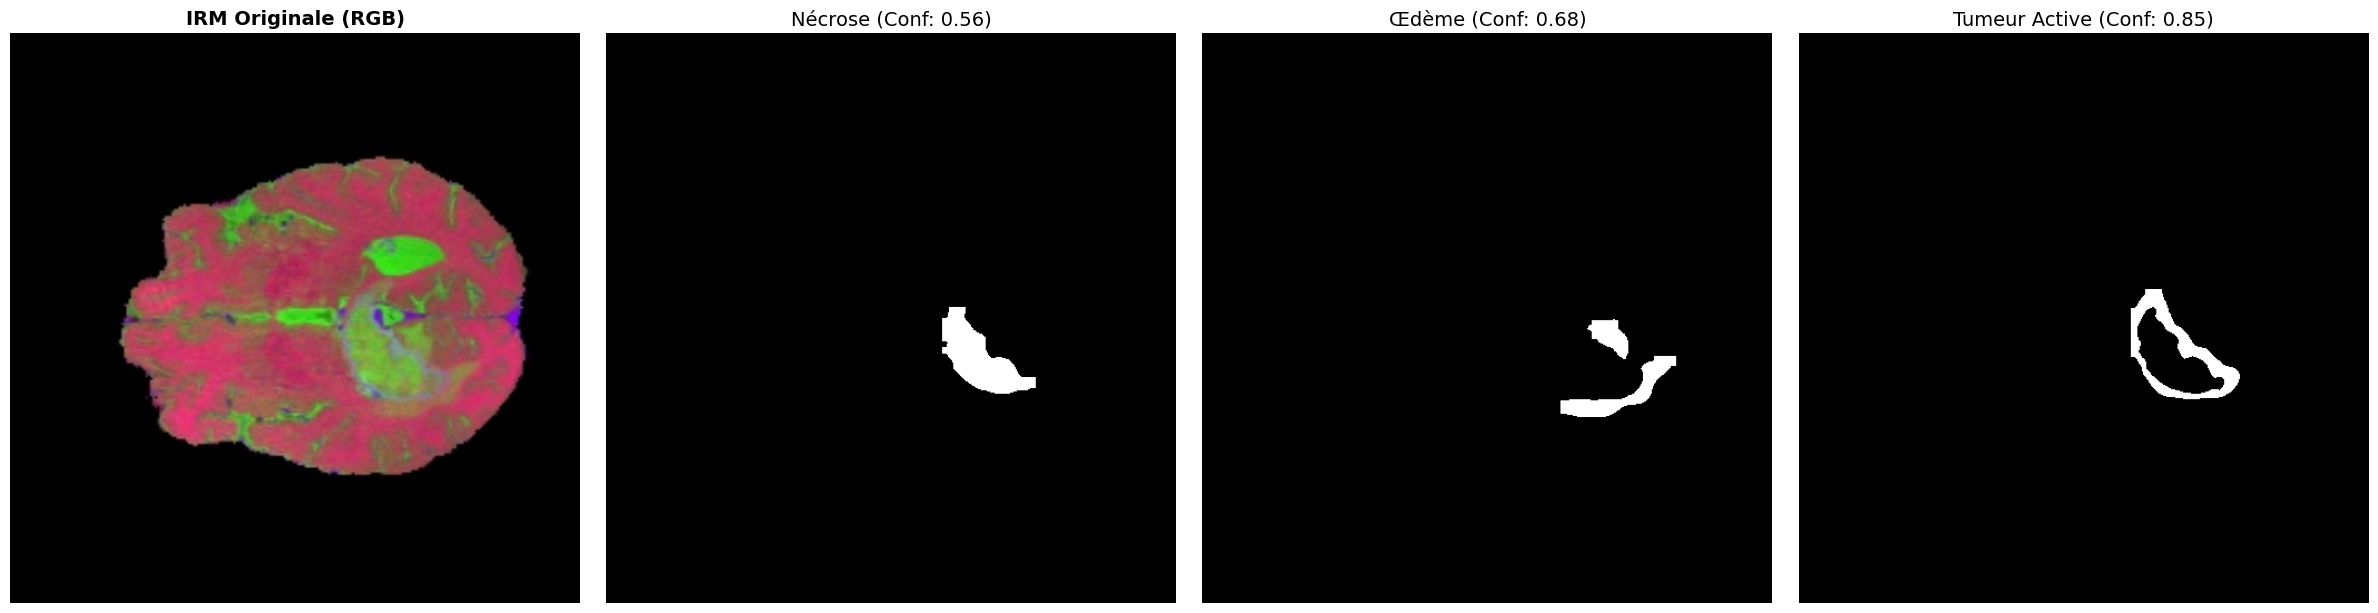

In [15]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import glob
import random
import os
import numpy as np

# --- CONFIGURATION ---
# On pointe vers ton modèle "Small" entraîné sur 7000 images (run2)
MODEL_PATH = '/content/runs/segment/brats_final_small2/weights/best.pt'
DATA_PATH = '/content/datasets/brats_yolo_multiclass/images/val/*.jpg'

print(f"1. Chargement du modèle : {MODEL_PATH}")

if not os.path.exists(MODEL_PATH):
    print("❌ ERREUR : Modèle introuvable. Vérifie le dossier 'runs'.")
else:
    model = YOLO(MODEL_PATH)
    val_images = glob.glob(DATA_PATH)

    if len(val_images) > 0:
        found_tumor = False
        attempt = 0

        # On cherche une image intéressante (avec tumeur)
        while not found_tumor and attempt < 30:
            attempt += 1
            test_img = random.choice(val_images)

            # Prédiction
            results = model.predict(test_img, conf=0.25, verbose=False)

            if results[0].masks is not None:
                found_tumor = True
                print(f"✅ Tumeur détectée sur : {os.path.basename(test_img)}")

                # Extraction des données
                masks_data = results[0].masks.data.cpu().numpy()
                class_indices = results[0].boxes.cls.cpu().numpy()
                conf_scores = results[0].boxes.conf.cpu().numpy() # <-- On récupère les scores !

                # Préparation des cartes sémantiques
                h, w = masks_data.shape[1], masks_data.shape[2]
                semantic_maps = {0: np.zeros((h, w)), 1: np.zeros((h, w)), 2: np.zeros((h, w))}

                # Dictionnaire pour stocker les scores max par classe
                class_scores = {0: [], 1: [], 2: []}

                for mask, cls, score in zip(masks_data, class_indices, conf_scores):
                    cls_id = int(cls)
                    semantic_maps[cls_id] = np.maximum(semantic_maps[cls_id], mask)
                    class_scores[cls_id].append(score)

                # --- AFFICHAGE ---
                fig, ax = plt.subplots(1, 4, figsize=(24, 6))

                # 1. Originale
                orig = cv2.resize(cv2.imread(test_img), (w, h))
                ax[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
                ax[0].set_title("IRM Originale (RGB)", fontsize=14, fontweight='bold')

                # 2, 3, 4. Les Tissus avec Scores
                titles = {0: "Nécrose", 1: "Œdème", 2: "Tumeur Active"}

                for i in range(3):
                    # Calcul du score moyen ou max pour l'affichage
                    if class_scores[i]:
                        score_txt = f" (Conf: {max(class_scores[i]):.2f})" # On affiche le score max
                    else:
                        score_txt = " (Non détecté)"

                    ax[i+1].imshow(semantic_maps[i], cmap='gray')
                    ax[i+1].set_title(f"{titles[i]}{score_txt}", fontsize=14)

                for a in ax: a.axis('off')
                plt.tight_layout()
                plt.show()

        if not found_tumor:
            print("⚠️ Aucune tumeur trouvée après 30 essais. Relance la cellule.")
    else:
        print("❌ Pas d'images trouvées.")